In [1]:
!pip install tqdm opencv-python scikit-learn xgboost tensorflow



In [2]:
!pip install --upgrade jupyter


In [3]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Path untuk folder gambar dan metadata
image_folder = r'C:\Users\ASUS\Documents\TA-cancer\Skin-Cancer\Skin-Cancer'  # Ganti dengan path folder gambar HAM10000 Anda
metadata_path = r'C:\Users\ASUS\Documents\TA-cancer\HAM10000_metadata.csv'  # Ganti dengan path metadata.csv

# Hyperparameters
image_size = (128, 128)
batch_size = 32
epochs = 10
learning_rate = 0.0001

# Memuat metadata
metadata = pd.read_csv(metadata_path)

# Label encoding untuk kelas
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['dx'])

# Memuat gambar dan label
images = []
labels = []

for index, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    img_path = os.path.join(image_folder, row['image_id'] + '.jpg')
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, image_size)
        images.append(img)
        labels.append(row['label'])

# Konversi ke array numpy
images = np.array(images)
labels = np.array(labels)

# Normalisasi gambar
images = images / 255.0

# Memisahkan dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Menggunakan augmentasi data pada training set
train_datagen = datagen.flow(X_train, y_train, batch_size=batch_size)
val_datagen = ImageDataGenerator().flow(X_test, y_test, batch_size=batch_size)

# Model Xception
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularisasi
predictions = Dense(len(le.classes_), activation='softmax')(x)
model_xception = Model(inputs=base_model_xception.input, outputs=predictions)

# Fine-tuning pada beberapa layer terakhir
for layer in base_model_xception.layers:
    layer.trainable = False  # Membekukan layer awal
for layer in base_model_xception.layers[-10:]:  # Melatih ulang 10 layer terakhir
    layer.trainable = True

# Kompilasi model
model_xception.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model MobileNet
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)

# Fine-tuning pada beberapa layer terakhir
for layer in base_model_mobilenet.layers:
    layer.trainable = False
for layer in base_model_mobilenet.layers[-10:]:
    layer.trainable = True

# Kompilasi model
model_mobilenet.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training model tanpa early stopping
print("Training Xception model with augmentation...")
history_xception = model_xception.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen
)

print("Training MobileNet model with augmentation...")
history_mobilenet = model_mobilenet.fit(
    train_datagen,
    epochs=epochs,
    validation_data=val_datagen
)



100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [04:34<00:00, 36.50it/s]


Training Xception model with augmentation...


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 200s 746ms/step - accuracy: 0.5672 - loss: 1.3058 - val_accuracy: 0.6880 - val_loss: 0.9268
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 187s 745ms/step - accuracy: 0.7147 - loss: 0.8200 - val_accuracy: 0.7169 - val_loss: 0.7853
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 188s 747ms/step - accuracy: 0.7390 - loss: 0.7358 - val_accuracy: 0.7209 - val_loss: 0.7769
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 188s 747ms/step - accuracy: 0.7412 - loss: 0.7048 - val_accuracy: 0.7334 - val_loss: 0.7308
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 188s 747ms/step - accuracy: 0.7519 - loss: 0.6762 - val_accuracy: 0.7244 - val_loss: 0.7725
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 186s 742ms/step - accuracy: 0.7554 - loss: 0.6551 - val_accuracy: 0.7274 - val_loss: 0.7411
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 187s 743ms/step - accuracy: 0.7761 - loss: 0.6117 - val_accuracy: 0.7269 - val_loss: 0.7296
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 189s 751ms/step - accuracy: 0.7629 -

In [1]:
import joblib

# # Save traditional models
# joblib.dump(rf_model, "random_forest_model.joblib")
# joblib.dump(knn_model, "knn_model.joblib")
# joblib.dump(svm_model, "svm_model.joblib")
# joblib.dump(xgb_model, "xgboost_model.joblib")
# joblib.dump(stacking_model, "stacking_model.joblib")

# Save deep learning models
xception_model.save("xception_model.keras")
mobilenet_model.save("mobilenet_model.keras")

print("Model telah disimpan.")


NameError: name 'xception_model' is not defined

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 539ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step
--- Evaluation Metrics for Xception ---
Accuracy : 0.7659
Precision: 0.7582
Recall   : 0.7659
F1-Score : 0.7511

Classification Report:
              precision    recall  f1-score   support

       akiec       0.62      0.19      0.29        69
         bcc       0.51      0.47      0.49        93
         bkl       0.50      0.64      0.56       228
          df       0.78      0.25      0.38        28
         mel       0.58      0.36      0.44       226
          nv       0.85      0.92      0.89      1338
        vasc       0.93      0.62      0.74        21

    accuracy                           0.77      2003
   macro avg       0.68      0.49      0.54      2003
weighted avg       0.76      0.77      0.75      2003



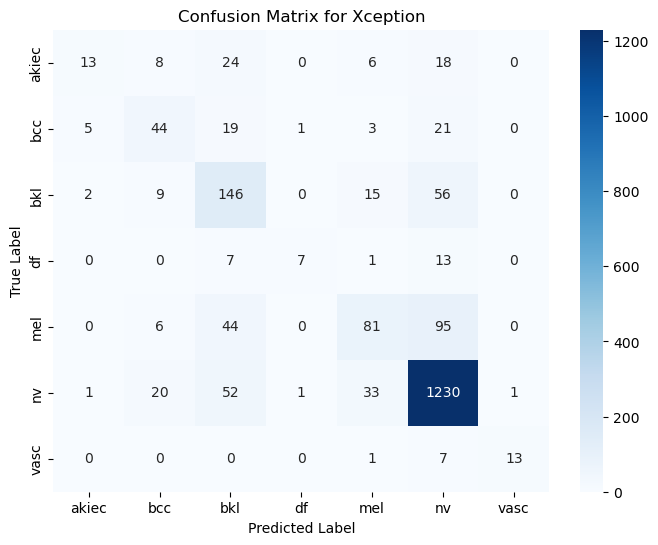

--- Evaluation Metrics for MobileNet ---
Accuracy : 0.7589
Precision: 0.7508
Recall   : 0.7589
F1-Score : 0.7356

Classification Report:
              precision    recall  f1-score   support

       akiec       0.88      0.20      0.33        69
         bcc       0.59      0.14      0.23        93
         bkl       0.48      0.62      0.54       228
          df       0.64      0.25      0.36        28
         mel       0.52      0.37      0.43       226
          nv       0.84      0.93      0.89      1338
        vasc       0.77      0.48      0.59        21

    accuracy                           0.76      2003
   macro avg       0.67      0.43      0.48      2003
weighted avg       0.75      0.76      0.74      2003



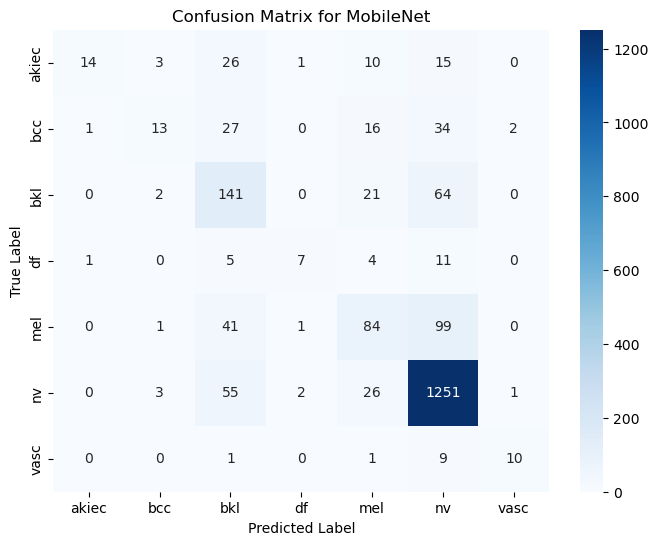

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict classes for test set using both models
y_pred_xception = np.argmax(model_xception.predict(X_test), axis=1)
y_pred_mobilenet = np.argmax(model_mobilenet.predict(X_test), axis=1)

# Function to print metrics and plot confusion matrix
def evaluate_model(y_true, y_pred, model_name, class_names):
    print(f"--- Evaluation Metrics for {model_name} ---")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}\n")
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Get class names from label encoder
class_names = le.classes_

# Evaluate Xception model
evaluate_model(y_test, y_pred_xception, "Xception", class_names)

# Evaluate MobileNet model
evaluate_model(y_test, y_pred_mobilenet, "MobileNet", class_names)


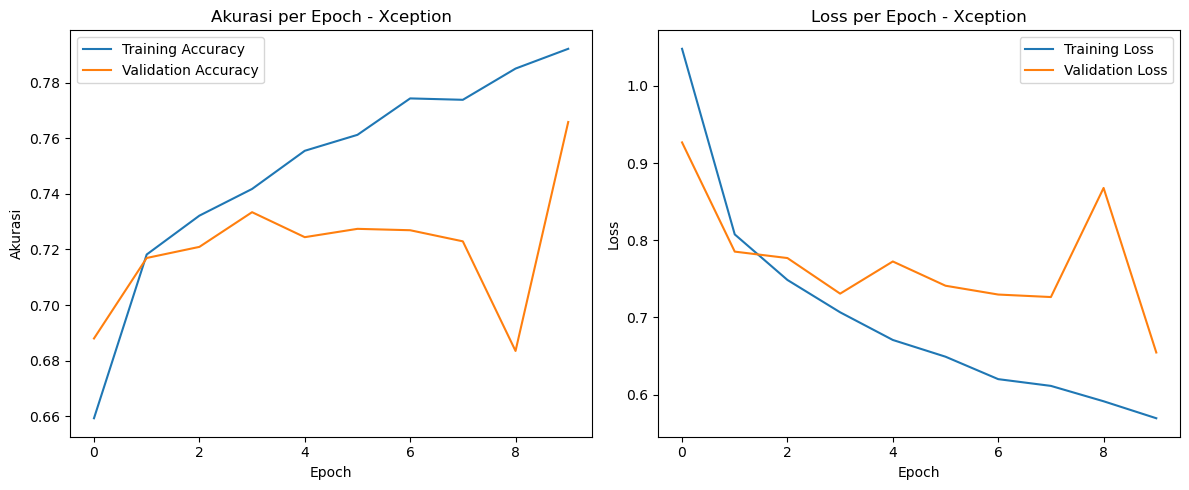

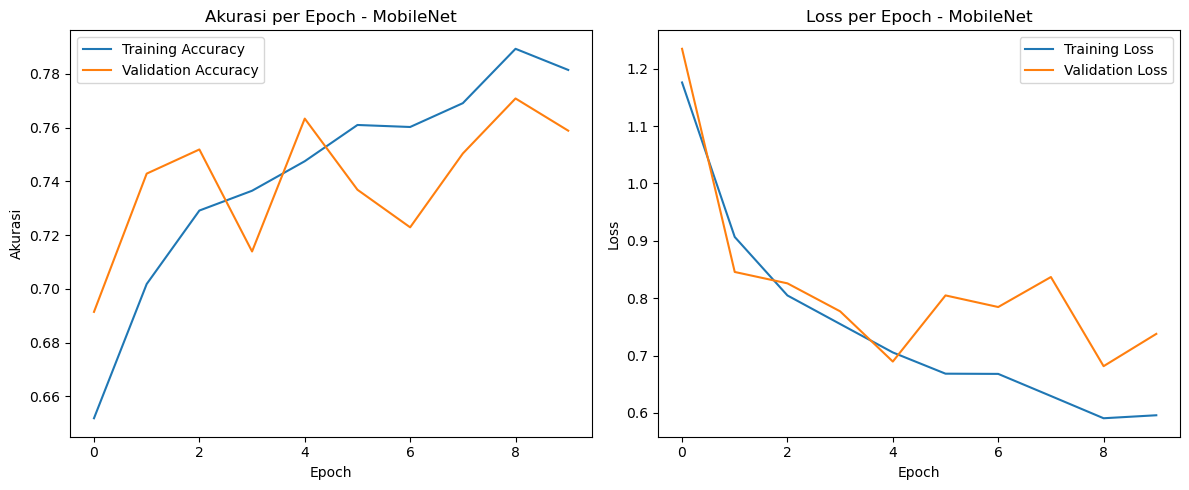

In [5]:
import matplotlib.pyplot as plt

# Fungsi untuk plot akurasi dan loss
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Akurasi per Epoch - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss per Epoch - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot grafik
plot_history(history_xception, "Xception")
plot_history(history_mobilenet, "MobileNet")


63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step


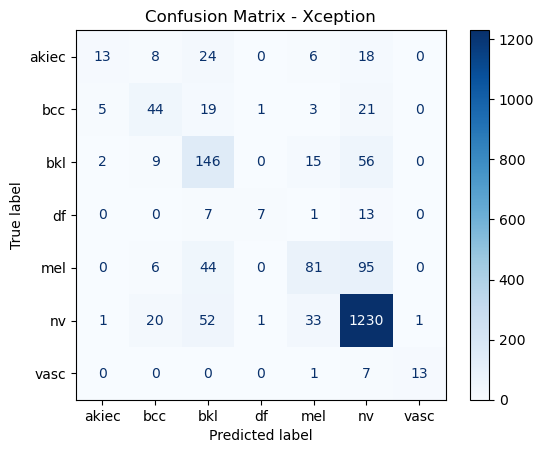

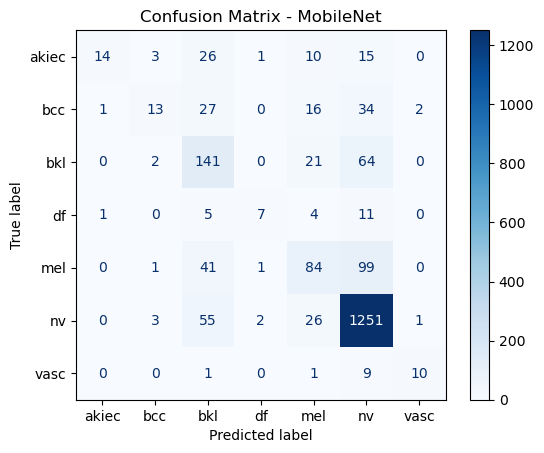

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Prediksi dan argmax
y_pred_x = model_xception.predict(X_test)
y_pred_x = np.argmax(y_pred_x, axis=1)

y_pred_m = model_mobilenet.predict(X_test)
y_pred_m = np.argmax(y_pred_m, axis=1)

# Confusion matrix Xception
cm_x = confusion_matrix(y_test, y_pred_x)
disp_x = ConfusionMatrixDisplay(confusion_matrix=cm_x, display_labels=le.classes_)
disp_x.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Xception")
plt.show()

# Confusion matrix MobileNet
cm_m = confusion_matrix(y_test, y_pred_m)
disp_m = ConfusionMatrixDisplay(confusion_matrix=cm_m, display_labels=le.classes_)
disp_m.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MobileNet")
plt.show()
